In [1]:


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from sklearn.model_selection import train_test_split
from numpy.random import normal
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import inferpy as inf



C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:



n_points = 750    # number of datapoints
n_cat = 6   # number of categories
noise = 0.1     # determine noise to add to the dataset




def toy_data_set(categories, noise, N):
    # A dataset that in someplaces are impossible to seperate to different categories
    # (depending on the noise), making it ideal to test out bayesian inference. It is better 
    # to see the plot than me explaining what is happening in this fuction

    theta = np.arange(0, np.pi, np.pi/(N+1))[:N]
    a = 1
    b = .1

    X = np.zeros((N*categories, 3))
    cat = []
    catnr = 0
    k = 0

    for dt in np.arange(0, ((categories-1)*2) + 0.1, 2):

        if k % 2 == 0:
            number = -1
        else:
            number = 1

        s1 = normal(loc = 0, scale = noise, size= N)
        s2 = normal(loc = 0, scale = noise, size= N)
        s3 = normal(loc = 0, scale = noise/2, size= N)
        x = a*np.cos(theta + dt)*np.exp(b*theta) + s1 
        y = a*np.sin(theta + dt)*np.exp(b*theta) + s2
        z = np.exp(np.linspace(1, 2, N)[::-1])
        z = (((z - np.min(z))/np.max(z)) * number) + s3

        X[N*k:N*(k+1), 0], X[N*k:N*(k+1), 1], X[N*k:N*(k+1), 2] = x, y, z
        cat.append(np.zeros(len(x)) + catnr)
        catnr += 1
        k += 1

    X = X / X.max(axis=0)
    y = np.concatenate(cat)
    return(X,y)



# Getting the data and splitting it 50/50, and this is what I need help with.
# Anything else than 50/50 split is not working with the posterior_predictive fuction
X, y = toy_data_set(categories = n_cat, noise = noise, N = n_points)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.5)




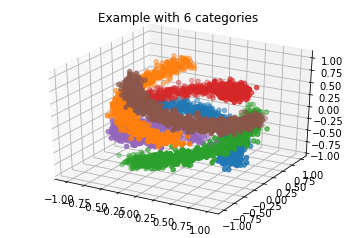

In [3]:


def plot(X, y):
    """ Plot as a function, so we can easily skip it if we want """
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for k in np.unique(y):
      index_cat_n = np.where(y == k)[0]
      ax.scatter3D(X[index_cat_n,0], X[index_cat_n,1], X[index_cat_n,2])
    ax.set_title('Example with '+str(n_cat)+' categories');
    plt.show()

plot(X, y)


In [4]:


D = np.shape(x_train)[1]    # number of features
K = 20    # number of mixture components

# Copy paste from MDN example

def neural_network(X):
    """loc, scale, logits = NN(x; theta)"""
    # 2 hidden layers with 150 hidden units
    net = tf.keras.layers.Dense(150, activation=tf.nn.relu)(X)
    net = tf.keras.layers.Dense(150, activation=tf.nn.relu)(net)
    locs = tf.keras.layers.Dense(K, activation=None)(net)
    scales = tf.keras.layers.Dense(K, activation=tf.exp)(net)
    logits = tf.keras.layers.Dense(K, activation=None)(net)
    return locs, scales, logits


@inf.probmodel
def mdn():
    with inf.datamodel():
        x = inf.Normal(loc = tf.ones([D]), scale = 1.0, name="x")
        locs, scales, logits = neural_network(x)
        y = inf.MixtureGaussian(locs, scales, logits=logits, name="y")

m = mdn()


@inf.probmodel
def qmodel():
        return;


In [5]:


VI = inf.inference.VI(qmodel(), epochs=3000)
m.fit({"y": y_train, "x":x_train}, VI)



 0 epochs	 22263.078125....................
 200 epochs	 10128.0380859375....................
 400 epochs	 10481.8388671875....................
 600 epochs	 9223.93359375....................
 800 epochs	 7206.296875....................
 1000 epochs	 6701.34033203125....................
 1200 epochs	 7379.40380859375....................
 1400 epochs	 5970.0380859375....................
 1600 epochs	 5288.6083984375....................
 1800 epochs	 6684.0244140625....................
 2000 epochs	 7459.865234375....................
 2200 epochs	 6051.42529296875....................
 2400 epochs	 5040.61181640625....................
 2600 epochs	 5711.5458984375....................
 2800 epochs	 10327.474609375....................


 Test accuracy :  0.5613333333333334
 Test accuracy after removing high std:  0.9466666666666667


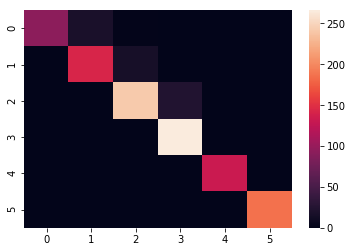

' Alright so hope this readable and just ask if something was unclear. I dont know much about\nTensorflow, neither MDN, so I am reading the great blog you linked too (http://cbonnett.github.io/MDN.html) '

In [6]:


y_pred_list = []
for i in range(500):
    y_test_pred = m.posterior_predictive(["y"], data = {"x": x_test}).sample()
    y_pred_list.append(y_test_pred)


y_mean = np.mean(y_pred_list, axis=0)
y_sigma = np.std(y_pred_list, axis=0)

y_pred = np.rint(y_mean).astype(int)


print("\n Test accuracy : ", np.sum(y_pred == y_test)/len(y_pred))


# This is just a quick use of the bayesian part of the network, 
# removing 1/2 of the points with the highest standard deviation
remove_indexes = y_sigma.argsort()[-int(len(y_sigma)/2):][::-1]
y_pred = np.delete(y_pred, remove_indexes)
y_test = np.delete(y_test, remove_indexes)


# print(np.sum(y_pred == y_test))
print(" Test accuracy after removing high std: ", np.sum(y_pred == y_test)/len(y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred))
plt.show()


""" Alright so hope this readable and just ask if something was unclear. I dont know much about
Tensorflow, neither MDN, so I am reading the great blog you linked too (http://cbonnett.github.io/MDN.html) """


